In [5]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [6]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39461/status,
Dashboard: /proxy/39461/status,Workers: 6
Total threads: 24,Total memory: 900.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35731,Workers: 6
Dashboard: /proxy/39461/status,Total threads: 24
Started: Just now,Total memory: 900.00 GiB
Comm: tcp://127.0.0.1:43593,Total threads: 4
Dashboard: /proxy/41603/status,Memory: 150.00 GiB
Nanny: tcp://127.0.0.1:46411,


In [7]:
import numpy as np
from netCDF4 import Dataset as nc

In [8]:
#src_file = '/g/data/e14/pc5520/ISF/BATHY/BedMachineAntarctica-v3_NEMOBAT.nc'
#ncfile_src = nc(src_file,'r')
#isfd_src = ncfile_src.variables['isfd'][:,:]
#thick_src = ncfile_src.variables['thick'][:,:]
#lon_src = ncfile_src.variables['lon'][:,:]
#lat_src = ncfile_src.variables['lat'][:,:]
#ncfile_src.close()

In [9]:
di = xr.open_dataset("/g/data/e14/pc5520/ISF/BATHY/BedMachineAntarctica-v3_NEMOBAT.nc")
#di = di.rename({"longitude": "lon", "latitude": "lat"})

In [10]:
hgrid_path = "/home/552/pc5520/forcing_files/ICB/ocean_hgrid_simple.nc"

dg = xr.open_dataset(hgrid_path)[["x", "y"]]
dg = dg.rename({"x": "lon", "y": "lat"}).set_coords(["lon", "lat"])

In [11]:
regridder = xe.Regridder(di, dg, "bilinear")

In [12]:
data_regrided = regridder(di)

In [13]:
data_regrided

<xarray.Dataset>
Dimensions:    (nyp: 2700, nxp: 3600)
Coordinates:
    lat        (nyp, nxp) float64 -81.13 -81.13 -81.13 ... 65.12 65.08 65.04
    lon        (nyp, nxp) float64 -280.0 -279.9 -279.8 -279.7 ... 80.0 80.0 80.0
Dimensions without coordinates: nyp, nxp
Data variables: (12/13)
    mask       (nyp, nxp) int8 2 2 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0 0 0
    firn       (nyp, nxp) float32 37.21 37.2 37.19 37.19 ... 0.0 0.0 0.0 0.0
    surface    (nyp, nxp) float32 3.967e+03 3.967e+03 3.96e+03 ... 0.0 0.0 0.0
    thickness  (nyp, nxp) float32 2.823e+03 2.701e+03 2.586e+03 ... 0.0 0.0 0.0
    bed        (nyp, nxp) float32 1.144e+03 1.266e+03 1.374e+03 ... 0.0 0.0 0.0
    errbed     (nyp, nxp) float32 33.72 34.92 37.15 31.81 ... 0.0 0.0 0.0 0.0
    ...         ...
    dataid     (nyp, nxp) int8 1 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    geoid      (nyp, nxp) int16 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0
    thick      (nyp, nxp) float64 2.823e+03 2.701e+03 2.586e+03 ... 0.0 0.0 0.0
    isfd       (nyp, nxp) float64 1.144e+03 1.266e+03 1.374e+03 ... 0.0 0.0 0.0
    test       (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    msk_oce    (nyp, nxp) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

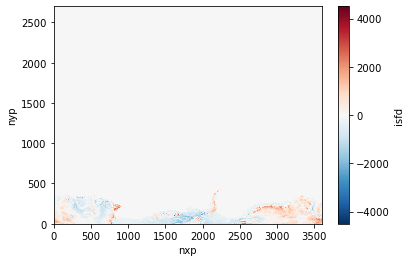

In [14]:
data_regrided.isfd.plot()

In [88]:
isfd = data_regrided.isfd.load()
surf = data_regrided.surface.load()
thick = data_regrided.thickness.load()
bed = data_regrided.bed.load()
msk = data_regrided.msk_oce.load()

In [89]:
from netCDF4 import Dataset as nc
import numpy.ma as ma

In [90]:
ncfile = nc('/g/data/e14/pc5520/ISF/BATHY_m100/xe_regrid_isfd.nc','w')
nyp = data_regrided.nyp
nxp = data_regrided.nxp
dnyp = ncfile.createDimension('nyp', nyp.shape[0])
dnxp = ncfile.createDimension('nxp', nxp.shape[0])
visfd = ncfile.createVariable('isf_draft', 'float',('nyp', 'nxp'))
vsurf = ncfile.createVariable('surf', 'float',('nyp', 'nxp'))
vthick = ncfile.createVariable('thick', 'float',('nyp', 'nxp'))
vbed = ncfile.createVariable('Bathymetry', 'float',('nyp', 'nxp'))
vmsk = ncfile.createVariable('msk', 'float',('nyp', 'nxp'))
visfd[:,:] = isfd
vsurf[:,:] = surf
vthick[:,:] = thick
vbed[:,:] = bed
vmsk[:,:] = msk
ncfile.close()